In [1]:
import pandas as pd
import json
from pprint import pprint
from collections import Counter
import string
import re
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
import os
from pprint import pprint



### Prepare Covid Data

In [2]:
def read_file(file_name):
    '''
    This function will read the file containing tweet ids sperating by lines (in groups)
    '''
    all_ids = pd.read_table(file_name, sep='\n', header=None)
    return all_ids

In [3]:
tweet_covid = pd.read_json("../data/covid_data_prepared.json")
predict_label = pd.read_csv("../data/covid_prediction.csv")

In [4]:
tweet_covid['label'] = predict_label['Predicted']
tweet_covid['source_text'] = tweet_covid['data'].apply(lambda x: x[0]['text'].lower())

In [5]:
tweet_covid['label'].value_counts()

0    11729
1     3449
Name: label, dtype: int64

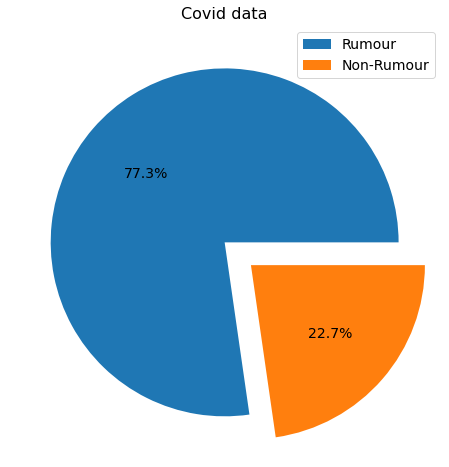

In [6]:
labels = ['Rumour', 'Non-Rumour']

tweet_covid['label'].value_counts().plot.pie(labels=['',''],
                                             explode=(0, 0.2),
                                             autopct='%1.1f%%', figsize=(8,8), fontsize=14, ylabel='')
plt.title('Covid data', fontsize=16)
plt.legend(labels, fontsize=14)

# Trend Analysis

In [7]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]


In [8]:
tweet_covid['time']=0
for i in range(len(tweet_covid)):
    tweet_covid['time'][i]=tweet_covid['data'][i][0]['created_at']
    

/var/folders/7h/cjlhkqns6ql6trqrp2lr1thc0000gn/T/ipykernel_81957/1523143277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_covid['time'][i]=tweet_covid['data'][i][0]['created_at']
/Users/feiyue/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
tweet_covid['time']

0        2020-06-14T20:20:28.000Z
1        2020-07-25T22:30:14.000Z
2        2020-05-30T02:22:04.000Z
3        2020-06-20T13:50:23.000Z
4        2020-07-02T14:55:36.000Z
                   ...           
15173    2020-04-19T13:04:52.000Z
15174    2020-05-14T22:12:54.000Z
15175    2020-07-02T11:18:47.000Z
15176    2020-05-05T19:06:35.000Z
15177    2020-04-14T17:40:09.000Z
Name: time, Length: 15178, dtype: object

In [10]:
#seperate  rumor and nonrumor data
rumor_data=[]
rumor_data_time=[]
nonrumor_data=[]
nonrumor_data_time=[]
for i in range(len(tweet_covid)):
    
    if tweet_covid['label'][i] == 1:
        rumor_data.append(tweet_covid['source_text'][i])
        rumor_data_time.append(tweet_covid['time'][i])
        
    else:
        nonrumor_data.append(tweet_covid['source_text'][i])
        nonrumor_data_time.append(tweet_covid['time'][i])

In [11]:
#get reply
tweet_covid['reply']=''
reply_data=[]
reply_data_r=[]
reply_data_nr=[]

for i in range(len(tweet_covid)):
    for j in range(1,len(tweet_covid['data'][i])):
        text = tweet_covid['data'][i][j]['text']
        tweet_covid['reply'][i]=tweet_covid['reply'][i]+text

for i in range(len(tweet_covid)):
    
    if tweet_covid['label'][i] == 1:
        reply_data_r.append(tweet_covid['reply'][i])
    else:
        reply_data_nr.append(tweet_covid['reply'][i])

/var/folders/7h/cjlhkqns6ql6trqrp2lr1thc0000gn/T/ipykernel_81957/1373628563.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_covid['reply'][i]=tweet_covid['reply'][i]+text


In [12]:
#tokenize data
processed_docs_r = [tokenize(doc) for doc in rumor_data]
processed_docs_nr = [tokenize(doc) for doc in nonrumor_data]

In [13]:
#prepare rumor data
word_count_dict_r = Dictionary(processed_docs_r)
    
# word must appear >10 times, and no more than 20% documents
word_count_dict_r.filter_extremes(no_below=20, no_above=0.1)  

# bow all document of corpus
bag_of_words_corpus_r = [word_count_dict_r.doc2bow(pdoc) for pdoc in processed_docs_r]  

In [14]:
#prepare non-rumor data
word_count_dict_nr = Dictionary(processed_docs_nr)
    
# word must appear >10 times, and no more than 20% documents
word_count_dict_nr.filter_extremes(no_below=20, no_above=0.1)  

# bow all document of corpus
bag_of_words_corpus_nr = [word_count_dict_nr.doc2bow(pdoc) for pdoc in processed_docs_nr]  

In [15]:
#set model
model_name = "./model.lda"
if os.path.exists(model_name):
    lda_model = gensim.models.LdaModel.load(model_name)
    print ("loaded from old")
else:
    # preprocess()
    lda_model = gensim.models.LdaModel(bag_of_words_corpus_nr, num_topics=100, id2word=word_count_dict_nr, passes=5)#num_topics: the maximum numbers of topic that can provide
    lda_model.save(model_name)
    print ("loaded from new")


loaded from old


In [16]:
rumour_topics_num = len(processed_docs_r)
nonrumour_topics_num = len(processed_docs_nr)
print('number of rumour_topics',rumour_topics_num,'number of nonrumour_topics',nonrumour_topics_num)

number of rumour_topics 3449 number of nonrumour_topics 11729


In [17]:
#rumour topic model
ldamodel_rumour = gensim.models.LdaModel(bag_of_words_corpus_r, num_topics=10, id2word = word_count_dict_r ,passes=30,random_state = 1)   #分为10个主题
print(ldamodel_rumour.print_topics(num_topics=10, num_words=15)) 


[(0, '0.063*"pence" + 0.055*"president" + 0.047*"lockdown" + 0.042*"house" + 0.041*"white" + 0.029*"mike" + 0.026*"days" + 0.025*"social" + 0.020*"tested" + 0.019*"spread" + 0.019*"vice" + 0.018*"hoax" + 0.017*"distancing" + 0.016*"force" + 0.015*"positive"'), (1, '0.097*"china" + 0.046*"chinese" + 0.046*"democrats" + 0.034*"virus" + 0.032*"help" + 0.027*"cuomo" + 0.021*"homes" + 0.019*"nursing" + 0.019*"party" + 0.019*"die" + 0.019*"india" + 0.018*"world" + 0.016*"watch" + 0.016*"communist" + 0.015*"left"'), (2, '0.056*"amp" + 0.056*"today" + 0.054*"news" + 0.048*"biden" + 0.026*"president" + 0.026*"america" + 0.026*"breaking" + 0.022*"joe" + 0.022*"report" + 0.021*"pandemic" + 0.019*"cnn" + 0.018*"americans" + 0.016*"stop" + 0.016*"says" + 0.015*"briefing"'), (3, '0.104*"state" + 0.059*"texas" + 0.053*"home" + 0.047*"gov" + 0.036*"stay" + 0.033*"spread" + 0.026*"california" + 0.024*"read" + 0.024*"order" + 0.022*"governor" + 0.020*"breaking" + 0.019*"orders" + 0.018*"economy" + 0.017

In [18]:
#nonrumour topic model
ldamodel_nonrumour = gensim.models.LdaModel(bag_of_words_corpus_nr, num_topics=10, id2word = word_count_dict_nr ,passes=30,random_state = 1)   #分为10个主题
print(ldamodel_nonrumour.print_topics(num_topics=10, num_words=15)) 

[(0, '0.026*"amp" + 0.023*"pandemic" + 0.021*"lockdown" + 0.013*"minister" + 0.013*"country" + 0.012*"time" + 0.012*"government" + 0.009*"today" + 0.009*"says" + 0.009*"relief" + 0.009*"thank" + 0.008*"economic" + 0.008*"crisis" + 0.008*"continue" + 0.008*"india"'), (1, '0.029*"year" + 0.017*"read" + 0.016*"old" + 0.016*"police" + 0.016*"story" + 0.015*"johnson" + 0.014*"man" + 0.013*"watch" + 0.013*"family" + 0.012*"boris" + 0.011*"hospital" + 0.011*"morning" + 0.010*"cummings" + 0.010*"died" + 0.009*"dead"'), (2, '0.038*"death" + 0.036*"china" + 0.026*"uk" + 0.025*"patients" + 0.021*"died" + 0.018*"rate" + 0.017*"countries" + 0.017*"world" + 0.015*"people" + 0.013*"april" + 0.013*"amp" + 0.013*"toll" + 0.011*"deaths" + 0.010*"wuhan" + 0.010*"nigeria"'), (3, '0.031*"dr" + 0.026*"care" + 0.025*"lives" + 0.021*"fauci" + 0.016*"children" + 0.015*"patients" + 0.013*"schools" + 0.011*"contact" + 0.011*"doctors" + 0.011*"school" + 0.011*"medical" + 0.010*"hospital" + 0.010*"save" + 0.010*"t

In [19]:
#keyword frequency for rumour data
topic_list_r=pd.DataFrame()
topic_list_r['word']=''
topic_list_r['freq']=0
i=0
for topic in ldamodel_rumour.print_topics(num_words=10):
    termNumber = topic[0]
    listOfTerms = topic[1].split('+')
    
    for term in listOfTerms:
        listItems = term.split('*')
        topic_list_r.loc[i]=[listItems[1], float(listItems[0])]
        i=i+1
topic_list_r

,word,freq
0,"""pence""",0.063
1,"""president""",0.055
2,"""lockdown""",0.047
3,"""house""",0.042
4,"""white""",0.041
...,...,...
95,"""americans""",0.021
96,"""fight""",0.018
97,"""sick""",0.017
98,"""national""",0.016


In [20]:
#keyword frequency for non-rumour data
topic_list_nr=pd.DataFrame()
topic_list_nr['word']=''
topic_list_nr['freq']=0
i=0
for topic in ldamodel_nonrumour.print_topics(num_words=10):
    termNumber = topic[0]
    #print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    #print(listOfTerms)
    for term in listOfTerms:
        listItems = term.split('*')
        topic_list_nr.loc[i]=[listItems[1], float(listItems[0])]
        i=i+1
        #topic_list['word'].append(listItems[1])
        #print(listItems[1], listItems[0])
topic_list_nr

,word,freq
0,"""amp""",0.026
1,"""pandemic""",0.023
2,"""lockdown""",0.021
3,"""minister""",0.013
4,"""country""",0.013
...,...,...
95,"""reported""",0.023
96,"""day""",0.022
97,"""weeks""",0.021
98,"""today""",0.019


In [21]:
#Top 15 frequent keyword for rumour data
topic_list_sorted_r=topic_list_r.sort_values(by="freq" , ascending=False).head(15)
topic_list_sorted_r

,word,freq
80,"""new""",0.106
30,"""state""",0.104
10,"""china""",0.097
60,"""health""",0.091
81,"""cases""",0.078
40,"""amp""",0.075
0,"""pence""",0.063
31,"""texas""",0.059
20,"""amp""",0.056
21,"""today""",0.056


In [22]:
#Top 15 frequent keyword for non-rumour data
topic_list_sorted_nr = topic_list_nr.sort_values(by="freq" , ascending=False).head(15)
topic_list_sorted_nr

,word,freq
90,"""cases""",0.124
80,"""positive""",0.084
81,"""tested""",0.067
91,"""deaths""",0.060
60,"""president""",0.048
61,"""pandemic""",0.043
83,"""tests""",0.042
82,"""test""",0.042
40,"""amp""",0.039
20,"""death""",0.038


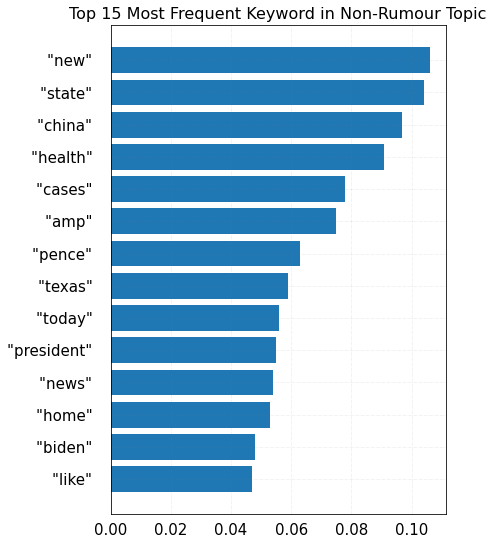

In [23]:
#plot Non-Rumour Topic
fig, ax = plt.subplots(figsize=(6, 9))
ax.barh(topic_list_sorted_r['word'],topic_list_sorted_r['freq'])
ax.set_title('Top 15 Most Frequent Keyword in Non-Rumour Topic', fontsize=16)
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
  
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5, labelsize=15)
ax.yaxis.set_tick_params(pad=10, labelsize=15)
  
# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
  
# Show top values
ax.invert_yaxis()

# Add annotation to bars
# for i in ax.patches:
#     plt.text(i.get_width()+0.01, i.get_y()+0.3,
#              str(round((i.get_width()), 2)),
#              fontsize=15, fontweight='bold',
#              color='grey')

plt.savefig('Top 15 Most Frequent Keyword in Non-Rumour Topic.png',bbox_inches = 'tight')

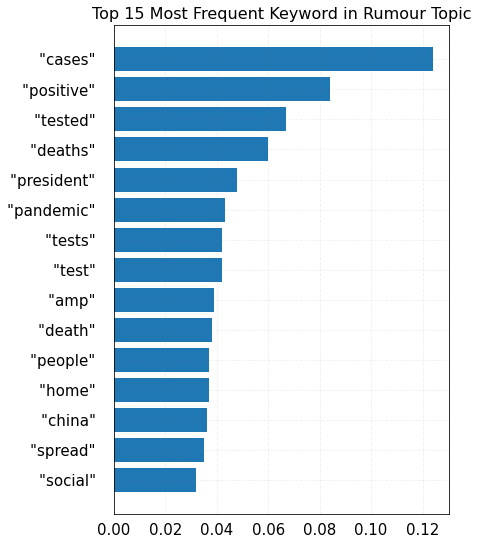

In [24]:
#plot Rumour Topic
fig, ax = plt.subplots(figsize=(6, 9))
ax.barh(topic_list_sorted_nr['word'],topic_list_sorted_nr['freq'])
ax.set_title('Top 15 Most Frequent Keyword in Rumour Topic', fontsize=16)
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
  
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5, labelsize=15)
ax.yaxis.set_tick_params(pad=10, labelsize=15)
  
# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
  
# Show top values
ax.invert_yaxis()

# Add annotation to bars
# for i in ax.patches:
#     plt.text(i.get_width()+0.01, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize=15, fontweight='bold',
#              color='grey')
plt.savefig('Top 15 Most Frequent Keyword in Rumour Topic.png',bbox_inches = 'tight')

In [25]:

for topic in ldamodel_nonrumour.print_topics(num_words=10):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')

0:
  "amp" (0.026)
  "pandemic" ( 0.023)
  "lockdown" ( 0.021)
  "minister" ( 0.013)
  "country" ( 0.013)
  "time" ( 0.012)
  "government" ( 0.012)
  "today" ( 0.009)
  "says" ( 0.009)
  "relief"( 0.009)
1:
  "year" (0.029)
  "read" ( 0.017)
  "old" ( 0.016)
  "police" ( 0.016)
  "story" ( 0.016)
  "johnson" ( 0.015)
  "man" ( 0.014)
  "watch" ( 0.013)
  "family" ( 0.013)
  "boris"( 0.012)
2:
  "death" (0.038)
  "china" ( 0.036)
  "uk" ( 0.026)
  "patients" ( 0.025)
  "died" ( 0.021)
  "rate" ( 0.018)
  "countries" ( 0.017)
  "world" ( 0.017)
  "people" ( 0.015)
  "april"( 0.013)
3:
  "dr" (0.031)
  "care" ( 0.026)
  "lives" ( 0.025)
  "fauci" ( 0.021)
  "children" ( 0.016)
  "patients" ( 0.015)
  "schools" ( 0.013)
  "contact" ( 0.011)
  "doctors" ( 0.011)
  "school"( 0.011)
4:
  "amp" (0.039)
  "need" ( 0.020)
  "workers" ( 0.019)
  "people" ( 0.018)
  "health" ( 0.016)
  "crisis" ( 0.015)
  "help" ( 0.014)
  "know" ( 0.013)
  "pandemic" ( 0.013)
  "let"( 0.011)
5:
  "home" (0.037)
 

In [26]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

rumour_datavis = pyLDAvis.gensim_models.prepare(ldamodel_rumour,bag_of_words_corpus_r,word_count_dict_r )
#print(rumour_data)
nonrumour_datavis = pyLDAvis.gensim_models.prepare(ldamodel_nonrumour,bag_of_words_corpus_nr,word_count_dict_nr )

/Users/feiyue/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [27]:
pyLDAvis.save_html(rumour_datavis, 'lda_pass_rumour.html')

In [28]:
pyLDAvis.save_html(nonrumour_datavis, 'lda_pass_nonrumour.html')

### Topic trend over Time

In [75]:
from pandas.core.frame import DataFrame
from datetime import datetime
#dt1 = datetime.strptime(time1,'%Y-%m-%dT%H:%M:%S.000Z')
rumor_data_time_dt = []
for i in rumor_data_time:
    rumor_data_time_dt.append(datetime.strptime(i,'%Y-%m-%dT%H:%M:%S.000Z'))
    
a=rumor_data
b=rumor_data_time_dt
c={"rumor_data" : a,
   "rumor_data_time_dt" : b}

data=DataFrame(c)
data.index = data["rumor_data_time_dt"]
data = data.sort_index()

In [76]:
data_sub_1 = data.iloc[:700]
data_sub_2 = data.iloc[700:2000]
data_sub_3 = data.iloc[2000:]

In [77]:
data_sub_1_rumor_data = list(data_sub_1["rumor_data"])
data_sub_2_rumor_data = list(data_sub_2["rumor_data"])
data_sub_3_rumor_data = list(data_sub_3["rumor_data"])

In [78]:
def divide_n_piece_df(data,n):
    len_all = len(data)
    len_one = len_all/n
    result_all = []
    for i in range(n): 
        sub_data = data.iloc[int(i*len_one):int((i+1)*len_one)]
        result_all.append(sub_data["rumor_data"])
    return result_all

In [79]:
def divide_n_piece(data,n):
    len_all = len(data)
    len_one = len_all/n
    result_all = []
    for i in range(n): 
        sub_data = data.iloc[int(i*len_one):int((i+1)*len_one)]
        result_all.append(list(sub_data["rumor_data"]))
    return result_all

In [80]:
result_all = divide_n_piece(data,4)

In [81]:
def divide_get_result(data,n):
    result_all = divide_n_piece(data,n)
    index = 0
    for i in result_all:
        print("--------------------stage"+ str(index) + "--------------------------------------------")
        get_topic(i)
        print()
        print()
        index = index +1

In [82]:
def get_topic(data_sub_1_rumor_data):
    processed_docs_r = [tokenize(doc) for doc in data_sub_1_rumor_data]
    word_count_dict_r = Dictionary(processed_docs_r)
    # word must appear >10 times, and no more than 20% documents
    word_count_dict_r.filter_extremes(no_below=20, no_above=0.1)  
    # bow all document of corpus
    bag_of_words_corpus_r = [word_count_dict_r.doc2bow(pdoc) for pdoc in processed_docs_r]  
    word_count_dict_r = Dictionary(processed_docs_r)
    
    # word must appear >10 times, and no more than 20% documents
    word_count_dict_r.filter_extremes(no_below=20, no_above=0.1)  

    # bow all document of corpus
    bag_of_words_corpus_r = [word_count_dict_r.doc2bow(pdoc) for pdoc in processed_docs_r] 
    ldamodel_rumour = gensim.models.LdaModel(bag_of_words_corpus_r, num_topics=20, id2word = word_count_dict_r ,passes=30,random_state = 1)   #分为10个主题
    #print(ldamodel_rumour.print_topics(num_topics=10, num_words=15)) 
    for topic in ldamodel_rumour.print_topics(num_words=10):
        termNumber = topic[0]
        print(topic[0], ':', sep='')
        listOfTerms = topic[1].split('+')
        for term in listOfTerms:
            listItems = term.split('*')
            print('  ', listItems[1], '(', listItems[0], ')', sep='')

In [83]:
divide_get_result(data,5)

--------------------stage0--------------------------------------------
0:
  "china" (0.731)
  "days" ( 0.139)
  "masks" ( 0.056)
  "chinese" ( 0.052)
  "world" ( 0.002)
  "media" ( 0.001)
  "fight" ( 0.001)
  "medical" ( 0.000)
  "million" ( 0.000)
  "government"( 0.000)
1:
  "says" (0.467)
  "ve" ( 0.337)
  "world" ( 0.163)
  "crisis" ( 0.008)
  "help" ( 0.001)
  "new" ( 0.001)
  "state" ( 0.001)
  "today" ( 0.001)
  "fight" ( 0.001)
  "million"( 0.001)
2:
  "time" (0.924)
  "china" ( 0.002)
  "going" ( 0.002)
  "spread" ( 0.002)
  "news" ( 0.002)
  "amp" ( 0.002)
  "media" ( 0.002)
  "state" ( 0.002)
  "million" ( 0.002)
  "democrats"( 0.002)
3:
  "cases" (0.821)
  "world" ( 0.106)
  "new" ( 0.006)
  "health" ( 0.004)
  "ve" ( 0.004)
  "public" ( 0.002)
  "amp" ( 0.002)
  "help" ( 0.001)
  "pelosi" ( 0.001)
  "outbreak"( 0.001)
4:
  "realdonaldtrump" (0.346)
  "today" ( 0.286)
  "american" ( 0.282)
  "health" ( 0.051)
  "like" ( 0.001)
  "outbreak" ( 0.001)
  "masks" ( 0.001)
  "lock

# source sentiment

In [29]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/feiyue/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Calculate the polarity score for non rumor and rumor data

In [30]:
rumour_score = [sia.polarity_scores(doc) for doc in rumor_data]
nonrumour_score = [sia.polarity_scores(doc) for doc in nonrumor_data]
nonrumour_score[0:5]

[{'neg': 0.098, 'neu': 0.837, 'pos': 0.065, 'compound': -0.128},
 {'neg': 0.145, 'neu': 0.725, 'pos': 0.13, 'compound': -0.1531},
 {'neg': 0.041, 'neu': 0.71, 'pos': 0.249, 'compound': 0.9136},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.089, 'neu': 0.809, 'pos': 0.102, 'compound': 0.1531}]

In [31]:
#reply sentiment 
rumour_reply_score = [sia.polarity_scores(doc) for doc in reply_data_r]
nonrumour_reply_score=[sia.polarity_scores(doc) for doc in reply_data_nr]

In [32]:

#get compound score for rumour and non-rumour data
nonrumour_reply_compound_score=[]
rumour_reply_compound_score=[]

nonrumour_source_compound_score=[]
rumour_source_compound_score=[]

for i in range(0,len(nonrumour_reply_score)):
    if nonrumour_reply_score[i]['compound'] !=0:
        nonrumour_reply_compound_score.append(nonrumour_reply_score[i]['compound'])
    
for i in range(0,len(rumour_reply_score)):
    if rumour_reply_score[i]['compound'] !=0:
        rumour_reply_compound_score.append(rumour_reply_score[i]['compound'])
    
for i in range(0,len(nonrumour_score)):
    nonrumour_source_compound_score.append(nonrumour_score[i]['compound'])
    
for i in range(0,len(rumour_score)):
    rumour_source_compound_score.append(rumour_score[i]['compound'])


### Plots for source data

Text(0, 0.5, 'Number of tweets')

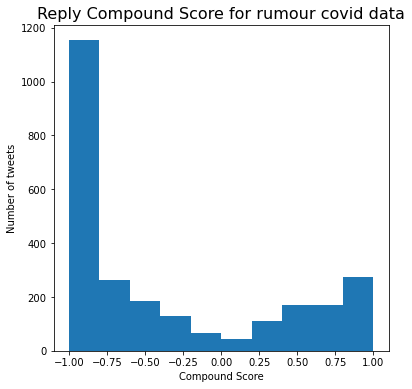

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Reply Compound Score for rumour covid data', fontsize=16)
plt.hist(rumour_reply_compound_score)
plt.xlabel ('Compound Score')
plt.ylabel ('Number of tweets')

Text(0, 0.5, 'Number of tweets')

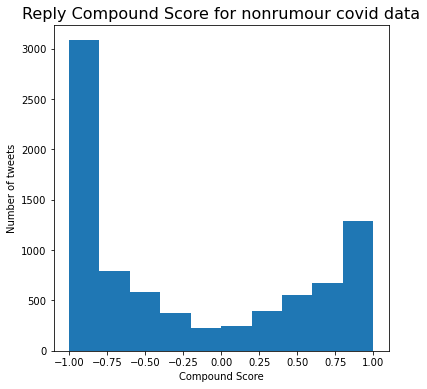

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Reply Compound Score for nonrumour covid data', fontsize=16)
plt.hist(nonrumour_reply_compound_score)
plt.xlabel ('Compound Score')
plt.ylabel ('Number of tweets')

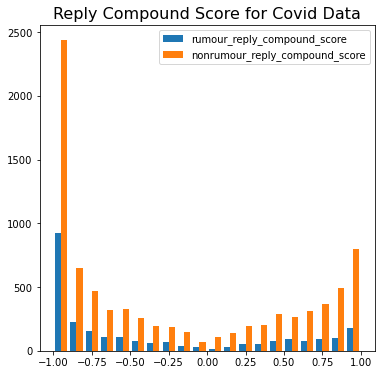

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Reply Compound Score for Covid Data', fontsize=16)
plt.hist([rumour_reply_compound_score,nonrumour_reply_compound_score],bins = 20,range = [-1,1],label = ['rumour_reply_compound_score','nonrumour_reply_compound_score'] )
plt.legend(loc='upper right')
plt.savefig('Reply Compound Score for Covid Data.png')

### Plots for reply data

Text(0, 0.5, 'Number of tweets')

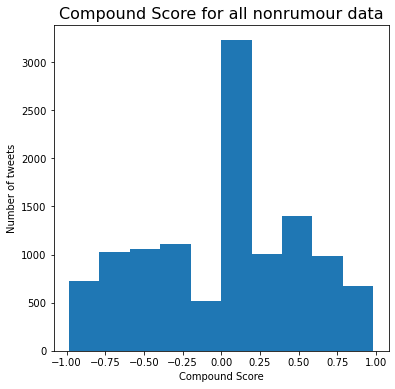

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Compound Score for all nonrumour data', fontsize=16)
plt.hist(nonrumour_source_compound_score)
plt.xlabel ('Compound Score')
plt.ylabel ('Number of tweets')

Text(0, 0.5, 'Number of tweets')

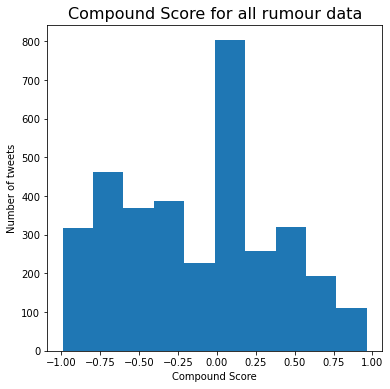

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Compound Score for all rumour data', fontsize=16)
plt.hist(rumour_source_compound_score)
plt.xlabel ('Compound Score')
plt.ylabel ('Number of tweets')

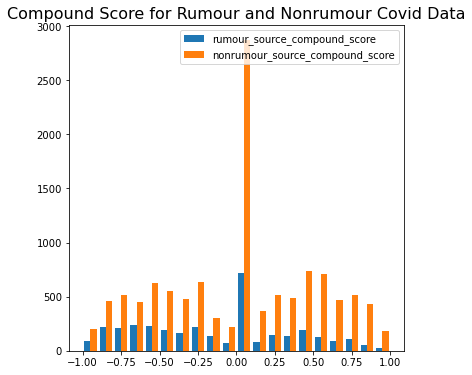

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Compound Score for Rumour and Nonrumour Covid Data', fontsize=16)
plt.hist([rumour_source_compound_score,nonrumour_source_compound_score],bins = 20,range = [-1,1],label = ['rumour_source_compound_score','nonrumour_source_compound_score'] )
plt.legend(loc='upper right')
plt.savefig("Compound Score for Covid tweets.png",bbox_inches = 'tight')

# User Analysis

In [39]:
from datetime import datetime
def process_line_train(tweet_list):
    result_list = []
    retweet_count = tweet_list[0]['public_metrics']['retweet_count']
    like_count = tweet_list[0]['public_metrics']['like_count']
    if 'public_metrics' in tweet_list[0]["user"].keys():
        user_followers_count = tweet_list[0]["user"]['public_metrics']['followers_count']
        user_listed_count = tweet_list[0]["user"]['public_metrics']['listed_count']
    else:
        user_followers_count = -1
        user_listed_count = -1
    result_list.append(retweet_count)
    result_list.append(like_count)
    result_list.append(user_followers_count)
    result_list.append(user_listed_count)
    
    time_vec = get_time_vec(line)
    return result_list+time_vec

In [40]:
def get_time_vec(line):
    time_vec = [0]*26
    time1 = line[0]["created_at"]
    for tweet in line:
        time2 = tweet["created_at"]
        time_gap = hour_gap(time1,time2)
        if time_gap<0:
            time_vec[0] = time_vec[0] + 1
        elif time_gap>48:
            time_vec[25] = time_vec[25] + 1
        else:
            index = int(time_gap/3) + 1
            time_vec[index] = time_vec[index] + 1
    return time_vec

In [41]:
def hour_gap(time1,time2):
    dt1 = datetime.strptime(time1,'%Y-%m-%dT%H:%M:%S.000Z')
    dt2 = datetime.strptime(time2,'%Y-%m-%dT%H:%M:%S.000Z')
    return (dt2 - dt1).seconds/3600

In [42]:
covid_info_all =[]
for i in range(len(tweet_covid)):
    line = tweet_covid.iloc[i]["data"]
    covid_info_all.append(process_line_train(line))

In [43]:
covid_info_all_user_df = pd.DataFrame(covid_info_all)

In [44]:
covid_user_df=pd.DataFrame()

In [45]:
covid_user_df['retweet_count'] = covid_info_all_user_df[0]
covid_user_df['like_count'] = covid_info_all_user_df[1]
covid_user_df['user_followers_count'] = covid_info_all_user_df[2]
covid_user_df['user_listed_count'] = covid_info_all_user_df[3]

In [48]:
covid_user_df['label']=tweet_covid['label']

In [49]:
covid_user_df

,retweet_count,like_count,user_followers_count,user_listed_count,label
0,25,263,45010,274,0
1,479,581,297487,5498,1
2,72,165,4365834,29068,1
3,785,1954,204254,2065,0
4,256,469,1179435,6316,1
...,...,...,...,...,...
15173,2618,5423,11719,11,0
15174,606,1686,7967,82,0
15175,955,3192,6176,228,1
15176,402,1464,328974,311,0


In [50]:
#nonrumour dataframe
covid_user_df_nr = covid_user_df.loc[(covid_user_df['label']  == 0)]
covid_user_df_nr

,retweet_count,like_count,user_followers_count,user_listed_count,label
0,25,263,45010,274,0
3,785,1954,204254,2065,0
5,3371,23569,19678882,26796,0
7,26,52,7808,207,0
9,256,416,311779,3928,0
...,...,...,...,...,...
15172,703,2192,488341,4255,0
15173,2618,5423,11719,11,0
15174,606,1686,7967,82,0
15176,402,1464,328974,311,0


### Plot for Users Analysis

5188082.921306164

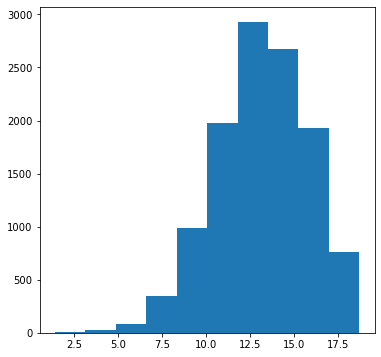

/Users/feiyue/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/feiyue/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/feiyue/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/feiyue/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/feiyue/opt/anaconda3/lib/python3.8/site-packages/past/builtins/mi

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.hist(covid_user_df_nr['user_followers_count'].apply(lambda x : math.log(x+0.0000001)))
covid_user_df_nr['user_followers_count'].mean()

In [52]:
covid_user_df_r = covid_user_df.loc[(covid_user_df['label']  == 1)]
covid_user_df_r

,retweet_count,like_count,user_followers_count,user_listed_count,label
1,479,581,297487,5498,1
2,72,165,4365834,29068,1
4,256,469,1179435,6316,1
6,102,503,58750,308,1
8,549,2070,613980,407,1
...,...,...,...,...,...
15156,12490,21929,47360,156,1
15161,488,553,871845,785,1
15167,1225,1108,1275017,9158,1
15169,2159,3412,10504,3,1


In [53]:
#the difference between user with more follower and user with less follower
covid_user_df.loc[(covid_user_df['user_followers_count']  >= 10000000)&(covid_user_df['label']  == 1)]
print(len(covid_user_df.loc[(covid_user_df['user_followers_count']  >= 10000000)&(covid_user_df['label']  == 1)])/(len(covid_user_df['user_followers_count']  >= 10000000)))
print(len(covid_user_df.loc[(covid_user_df['user_followers_count']  <= 1000)&(covid_user_df['label']  == 1)])/(len(covid_user_df['user_followers_count']  <= 1000)))


0.019436025826854657
0.0018447753327184083


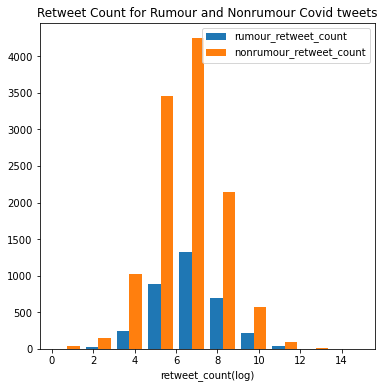

In [57]:
#rumour dataframe
import math
fig, ax = plt.subplots(figsize=(6, 6))
rumour_user = covid_user_df_r['retweet_count'].apply(lambda x : math.log(x+0.0000001))
nonrumour_user = covid_user_df_nr['retweet_count'].apply(lambda x : math.log(x+0.0000001))
plt.hist([rumour_user,nonrumour_user],bins = 10 , range = [0,15],label = ['rumour_retweet_count','nonrumour_retweet_count'])
plt.legend(loc='upper right')

ax.set_title('Retweet Count for Rumour and Nonrumour Covid tweets')
plt.xlabel ('retweet_count(log)')

plt.savefig("../plot/Retweet Count for Rumour and Nonrumour Covid tweets.png")
#covid_user_df_r['retweet_count'].mean()